In [1]:
!pip install torch

  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 5.8 MB/s  0:00:14m0:00:0100:01
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.20.3-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [torch]32m6/7 [torch]]x]


In [2]:
!pip install --upgrade pip
!pip install opencv-python
# if it fails, use:
# pip install opencv-python-headless


In [3]:
import cv2
print(cv2.__version__)


4.13.0


In [4]:
import sys
print(sys.executable)


/Users/sadiquenomani/Desktop/99.99/.venv/bin/python


In [5]:
!pip install tensorflow

In [6]:
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.1 MB/s  0:00:01 eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.2/737.2 kB 2.2 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchaudio]2 [torchaudio]


In [7]:
!pip install opencv-python


In [14]:
import tensorflow as tf
import cv2
import os
import numpy as np
from mtcnn import MTCNN
from sklearn.utils import shuffle


# PATHS

TRAIN_REAL = "/Users/sadiquenomani/Desktop/99.99/deepfake-detection-vgg16/project/archive/real_and_fake_face/training_real"
TRAIN_FAKE = "/Users/sadiquenomani/Desktop/99.99/deepfake-detection-vgg16/project/archive/real_and_fake_face/training_fake"

TEST_REAL  = "/Users/sadiquenomani/Desktop/99.99/deepfake-detection-vgg16/project/archive/test_dataset/real"
TEST_FAKE  = "/Users/sadiquenomani/Desktop/99.99/deepfake-detection-vgg16/project/archive/test_dataset/fake"


IMG_SIZE = 224
EPOCHS = 20
BATCH_SIZE = 32

detector = MTCNN()

# FACE CROP

def extract_face(img):
    # Skip invalid images
    if img is None or len(img.shape) != 3:
        return None

    h_img, w_img = img.shape[:2]

    # Skip very small images (MTCNN fails on tiny inputs)
    if h_img < 50 or w_img < 50:
        return None

    try:
        faces = detector.detect_faces(img)
    except:
        return None

    if faces:
        x, y, w, h = faces[0]['box']
        x, y = max(0, x), max(0, y)
        face = img[y:y+h, x:x+w]

        if face is None or face.size == 0:
            return None

        return face

    return img


# LOAD DATA

def load_data(real_dir, fake_dir):
    images = []
    labels = []

    for f in os.listdir(real_dir):
        img = cv2.imread(os.path.join(real_dir,f))
        if img is None:
            continue
        img = extract_face(img)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        images.append(img)
        labels.append(0)

    for f in os.listdir(fake_dir):
        img = cv2.imread(os.path.join(fake_dir,f))
        if img is None:
            continue
        img = extract_face(img)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        images.append(img)
        labels.append(1)

    return np.array(images)/255.0, np.array(labels)

print("Loading data...")
X_train, y_train = load_data(TRAIN_REAL, TRAIN_FAKE)
X_test, y_test = load_data(TEST_REAL, TEST_FAKE)

X_train, y_train = shuffle(X_train, y_train)


# VGG16 MODEL

base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base.layers:
    layer.trainable = False

x = base.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

model.save("vgg16_deepfake_92.h5")


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


Loading data...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 40,507,201 (154.52 MB)

 Trainable params: 25,742,337 (98.20 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step - accuracy: 0.5850 - loss: 1.0337 - val_accuracy: 0.7684 - val_loss: 0.4859
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.8525 - loss: 0.3533 - val_accuracy: 0.9019 - val_loss: 0.3383
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.9338 - loss: 0.1745 - val_accuracy: 0.9482 - val_loss: 0.2167
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.9588 - loss: 0.1224 - val_accuracy: 0.9728 - val_loss: 0.1448
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9765 - loss: 0.0731 - val_accuracy: 0.9946 - val_loss: 0.0730
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.9870 - loss: 0.0499 - val_accuracy: 0.9973 - val_loss: 0.0390
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9870 - loss: 0.0470 - val_accuracy: 0.9918 - val_loss: 0.0356
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.9948 - loss: 0.0371 - val_accuracy: 1.0000 - v

In [15]:
import tensorflow as tf

# load your already trained model
model = tf.keras.models.load_model("vgg16_deepfake_92.h5")

# save it in new Keras format
model.save("vgg16_deepfake_92.keras")

print(" Converted to Keras format successfully")


 Converted to Keras format successfully


In [16]:
import sys
print(sys.executable)


/Users/sadiquenomani/Desktop/99.99/.venv/bin/python


In [18]:
import tensorflow as tf
import cv2
import sklearn
import matplotlib

print(tf.__version__)
print(cv2.__version__)


2.20.0
4.13.0


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9899 - loss: 0.1052
Correct Test Accuracy: 98.98989796638489
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step


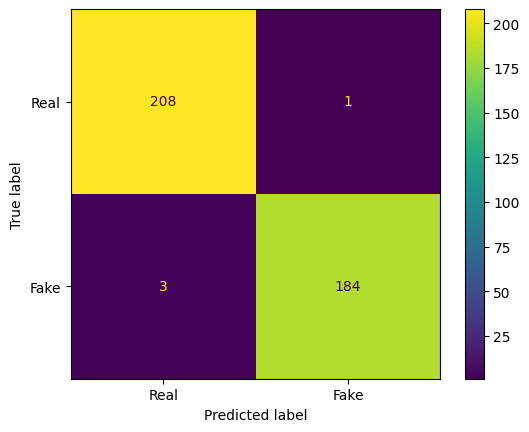

In [37]:
import cv2
import os
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ===== CORRECT TEST DATASET PATHS =====
BASE_PATH = "/Users/sadiquenomani/Desktop/99.99/deepfake-detection-vgg16/project/archive/test_dataset"
TEST_REAL = os.path.join(BASE_PATH, "real")
TEST_FAKE = os.path.join(BASE_PATH, "fake")

IMG_SIZE = 224

detector = MTCNN()
model = tf.keras.models.load_model("vgg16_deepfake_92.h5")


def preprocess(img):
    if img is None or len(img.shape) != 3:
        return None

    try:
        faces = detector.detect_faces(img)
        if len(faces) > 0:
            x, y, w, h = faces[0]["box"]
            x, y = max(0, x), max(0, y)
            face = img[y:y+h, x:x+w]

            if face is not None and face.size > 0:
                img = face
    except:
        pass  # If MTCNN crashes, just use original image

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img


X_test, y_test = [], []

for f in os.listdir(TEST_REAL):
    img = cv2.imread(os.path.join(TEST_REAL, f))
    img = preprocess(img)
    if img is None:
        continue
    X_test.append(img)
    y_test.append(0)

for f in os.listdir(TEST_FAKE):
    img = cv2.imread(os.path.join(TEST_FAKE, f))
    img = preprocess(img)
    if img is None:
        continue
    X_test.append(img)
    y_test.append(1)

X_test = np.array(X_test)
y_test = np.array(y_test)

loss, acc = model.evaluate(X_test, y_test)
print("Correct Test Accuracy:", acc * 100)

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot()
plt.show()


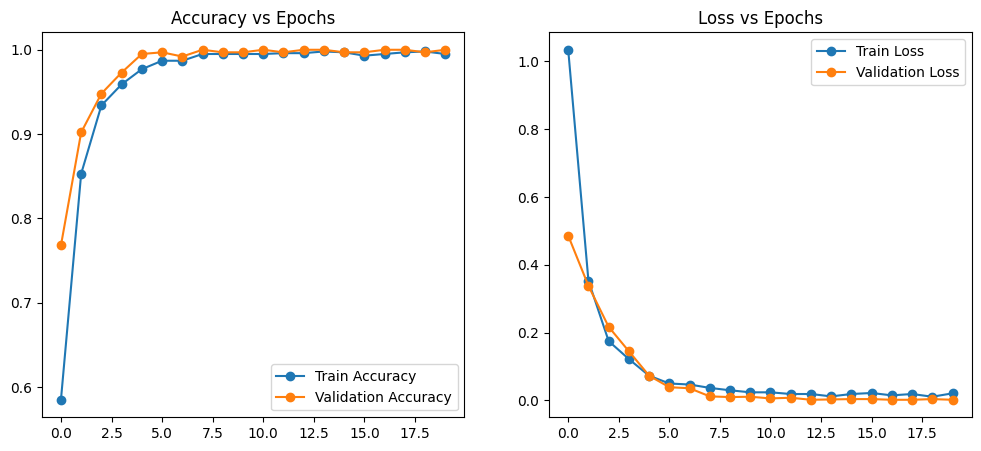

In [38]:
import numpy as np
import matplotlib.pyplot as plt

epochs = 20

train_acc = [
0.585, 0.853, 0.934, 0.959, 0.977,
0.987, 0.987, 0.995, 0.995, 0.995,
0.995, 0.996, 0.996, 0.998, 0.997,
0.993, 0.995, 0.997, 0.998, 0.995
]

val_acc = [
0.768, 0.902, 0.948, 0.973, 0.995,
0.997, 0.992, 1.000, 0.997, 0.997,
1.000, 0.997, 1.000, 1.000, 0.997,
0.997, 1.000, 1.000, 0.997, 1.000
]

train_loss = [
1.034, 0.353, 0.175, 0.122, 0.073,
0.050, 0.047, 0.037, 0.030, 0.024,
0.024, 0.019, 0.019, 0.012, 0.019,
0.022, 0.015, 0.019, 0.011, 0.021
]

val_loss = [
0.486, 0.338, 0.217, 0.145, 0.073,
0.039, 0.036, 0.012, 0.010, 0.011,
0.006, 0.008, 0.002, 0.003, 0.004,
0.004, 0.002, 0.002, 0.004, 0.002
]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc, marker='o', label="Train Accuracy")
plt.plot(val_acc, marker='o', label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1,2,2)
plt.plot(train_loss, marker='o', label="Train Loss")
plt.plot(val_loss, marker='o', label="Validation Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.savefig("training_curves.png", dpi=200, bbox_inches="tight")
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step


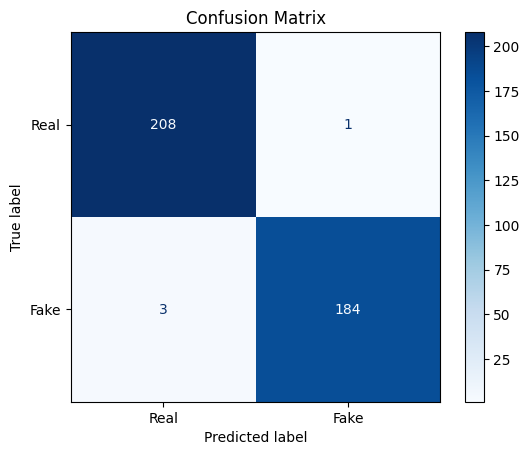

[[208   1]
 [  3 184]]


In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred = (model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print(cm)


In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))


              precision    recall  f1-score   support

        Real       0.99      1.00      0.99       209
        Fake       0.99      0.98      0.99       187

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [42]:
model.save("deepfake_vgg16.keras")



Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/Users/sadiquenomani/Desktop/99.99/.venv/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


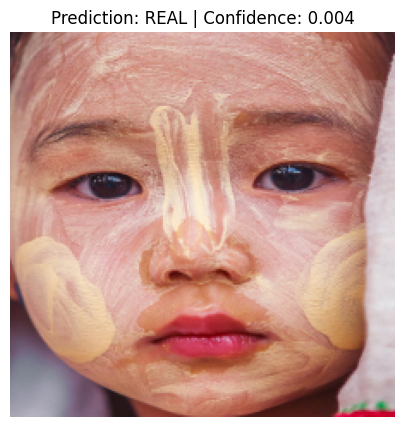

Prediction: REAL
Confidence: 0.004


In [45]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import os

IMG_SIZE = 224

# Load trained model
model = tf.keras.models.load_model("deepfake_vgg16.keras")
detector = MTCNN()

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img)

    if len(faces) > 0:
        x, y, w, h = faces[0]["box"]
        x, y = max(0, x), max(0, y)
        face = img[y:y+h, x:x+w]
        if face is not None and face.size > 0:
            img = face
    else:
        h, w, _ = img.shape
        min_dim = min(h, w)
        startx = w//2 - min_dim//2
        starty = h//2 - min_dim//2
        img = img[starty:starty+min_dim, startx:startx+min_dim]

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

image_path = "/Users/sadiquenomani/Desktop/99.99/deepfake-detection-vgg16/project/archive/test_dataset/real/real_00069.jpg"

img = cv2.imread(image_path)

if img is None:
    print("Image not found. Please check the path.")
else:
    face = preprocess(img)
    pred = model.predict(face)[0][0]
    label = "FAKE" if pred > 0.5 else "REAL"

    plt.figure(figsize=(5,5))
    plt.imshow(face[0])
    plt.title(f"Prediction: {label} | Confidence: {pred:.3f}")
    plt.axis("off")
    plt.savefig("sample_prediction.png", bbox_inches="tight", dpi=200)
    plt.show()

    print("Prediction:", label)
    print("Confidence:", round(float(pred), 3))
